# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
.......

# Business Problem
........

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

## Data Understanding

In [1]:
# Import all the necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Create directory path objects to begin viewing the data
train_pneu = 'data/chest_xray/train/PNEUMONIA'
train_normal = 'data/chest_xray/train/NORMAL'

val_pneu = 'data/chest_xray/val/PNEUMONIA'
val_normal = 'data/chest_xray/val/NORMAL'

test_pneu = 'data/chest_xray/test/PNEUMONIA'
test_normal = 'data/chest_xray/test/NORMAL'

In [3]:
# Count the amount of data in each directory's sub-directories
print('There are', len(os.listdir(train_pneu)), 'PNEUMONIA X-rays in the training set')
print('There are', len(os.listdir(train_normal)), 'NORMAL X-rays in the train set')
print('\n')
print('There are', len(os.listdir(val_pneu)), 'PNEUMONIA X-rays in the validation set')
print('There are', len(os.listdir(val_normal)), 'NORMAL X-rays in the validation set')
print('\n')
print('There are', len(os.listdir(test_pneu)), 'PNEUMONIA X-rays in the test set')
print('There are', len(os.listdir(test_normal)), 'NORMAL X-rays in the test set')

There are 3875 PNEUMONIA X-rays in the training set
There are 1341 NORMAL X-rays in the train set


There are 8 PNEUMONIA X-rays in the validation set
There are 8 NORMAL X-rays in the validation set


There are 390 PNEUMONIA X-rays in the test set
There are 234 NORMAL X-rays in the test set


In [4]:
# Move 50 images from the test data to the validation data
source_folder = test_pneu
destination_folder = val_pneu
files_to_move = os.listdir(source_folder)

for file in random.sample(files_to_move, 50):
    shutil.move(os.path.join(source_folder, file), destination_folder)
    print('There are', len(os.listdir(destination_folder)), 'PNEUMONIA X-rays in the validation set')

There are 9 PNEUMONIA X-rays in the validation set
There are 10 PNEUMONIA X-rays in the validation set
There are 11 PNEUMONIA X-rays in the validation set
There are 12 PNEUMONIA X-rays in the validation set
There are 13 PNEUMONIA X-rays in the validation set
There are 14 PNEUMONIA X-rays in the validation set
There are 15 PNEUMONIA X-rays in the validation set
There are 16 PNEUMONIA X-rays in the validation set
There are 17 PNEUMONIA X-rays in the validation set
There are 18 PNEUMONIA X-rays in the validation set
There are 19 PNEUMONIA X-rays in the validation set
There are 20 PNEUMONIA X-rays in the validation set
There are 21 PNEUMONIA X-rays in the validation set
There are 22 PNEUMONIA X-rays in the validation set
There are 23 PNEUMONIA X-rays in the validation set
There are 24 PNEUMONIA X-rays in the validation set
There are 25 PNEUMONIA X-rays in the validation set
There are 26 PNEUMONIA X-rays in the validation set
There are 27 PNEUMONIA X-rays in the validation set
There are 28 

In [5]:
# Move another 50 images from the other sub-directory to the appropriate folder
source_folder2 = test_normal
destination_folder2 = val_normal
files_to_move2 = os.listdir(source_folder2)

for file in random.sample(files_to_move2, 50):
    shutil.move(os.path.join(source_folder2, file), destination_folder2)
    print('There are', len(os.listdir(destination_folder2)), 'NORMAL X-rays in the validation set')

There are 9 NORMAL X-rays in the validation set
There are 10 NORMAL X-rays in the validation set
There are 11 NORMAL X-rays in the validation set
There are 12 NORMAL X-rays in the validation set
There are 13 NORMAL X-rays in the validation set
There are 14 NORMAL X-rays in the validation set
There are 15 NORMAL X-rays in the validation set
There are 16 NORMAL X-rays in the validation set
There are 17 NORMAL X-rays in the validation set
There are 18 NORMAL X-rays in the validation set
There are 19 NORMAL X-rays in the validation set
There are 20 NORMAL X-rays in the validation set
There are 21 NORMAL X-rays in the validation set
There are 22 NORMAL X-rays in the validation set
There are 23 NORMAL X-rays in the validation set
There are 24 NORMAL X-rays in the validation set
There are 25 NORMAL X-rays in the validation set
There are 26 NORMAL X-rays in the validation set
There are 27 NORMAL X-rays in the validation set
There are 28 NORMAL X-rays in the validation set
There are 29 NORMAL X

In [6]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216,
                                                           seed=seed)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=524,
                                                           seed=seed)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=116,
                                                           seed=seed)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


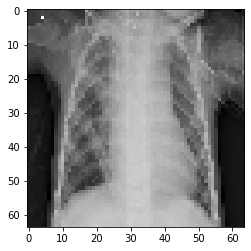

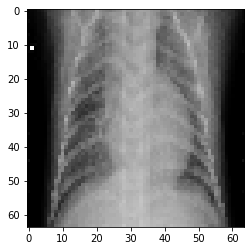

In [7]:
# Plot some images
plt.imshow(train_images[17]/255)
plt.show()

plt.imshow(train_images[4200]/255)
plt.show()

In [8]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(524, 64, 64, 3)
(524, 2)

Validation Data Shape:
(116, 64, 64, 3)
(116, 2)


In [9]:
# List the classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
# Reshape the labels
y_train_labels = train_labels.T[[1]]
y_test_labels = test_labels.T[[1]]
y_val_labels = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(y_train_labels))
print(np.shape(y_test_labels))
print(np.shape(y_val_labels))

(1, 5216)
(1, 524)
(1, 116)


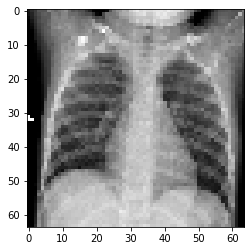

[0.]


In [11]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[1400]/255)
plt.show()
print(y_train_labels[:, 1400])

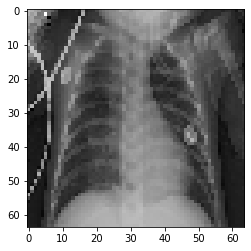

[1.]


In [12]:
# Confirm that the image matches with its corresponding label
plt.imshow(train_images[14]/255)
plt.show()
print(y_train_labels[:, 14])

## Modeling

### Baseline Model:

In [13]:
# Reshape the train, test, and validation images for modeling
X_train = train_images.reshape(5216, -1)
X_test = test_images.reshape(524, -1)
X_val = val_images.reshape(116, -1)

# Preview the shape of each newly-formed objects
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(5216, 12288)
(524, 12288)
(116, 12288)


In [14]:
# Standardize the datasets
X_train_final = X_train/255
X_test_final = X_test/255
X_val_final = X_val/255

In [15]:
# Reshape the labels for modeling
y_train = np.reshape(train_labels[:, 0], (5216, 1))
y_test = np.reshape(test_labels[:, 0], (524, 1))
y_val = np.reshape(val_labels[:, 0], (116, 1))

# Check the shape of the transformed labels 
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(5216, 1)
(524, 1)
(116, 1)


In [16]:
# Create a dense baseline neural network
baseline_model = Sequential()
baseline_model.add(Dense(32, activation='relu', input_shape=(12288, )))
baseline_model.add(Dense(8, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the baseline model
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

# List a summary of the baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                393248    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 393,521
Trainable params: 393,521
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the baseline model
baseline = baseline_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 13ms/step - loss: 0.6334 - acc: 0.7809 - val_loss: 0.5459 - val_acc: 0.7414
Epoch 2/50
82/82 [==============================] - 1s 10ms/step - loss: 0.3736 - acc: 0.8572 - val_loss: 0.5067 - val_acc: 0.7931
Epoch 3/50
82/82 [==============================] - 1s 10ms/step - loss: 0.3271 - acc: 0.8769 - val_loss: 1.0291 - val_acc: 0.5517
Epoch 4/50
82/82 [==============================] - 1s 9ms/step - loss: 0.2995 - acc: 0.8963 - val_loss: 0.8023 - val_acc: 0.6552
Epoch 5/50
82/82 [==============================] - 1s 9ms/step - loss: 0.2757 - acc: 0.9068 - val_loss: 0.6003 - val_acc: 0.7328
Epoch 6/50
82/82 [==============================] - 1s 10ms/step - loss: 0.2589 - acc: 0.9145 - val_loss: 1.3224 - val_acc: 0.6034
Epoch 7/50
82/82 [==============================] - 1s 10ms/step - loss: 0.2474 - acc: 0.9178 - val_loss: 1.4699 - val_acc: 0.5862
Epoch 8/50
82/82 [==============================] - 1s 10ms/step - loss: 0.2246 - acc

In [19]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{baseline_model.evaluate(X_train_final, y_train)}')
print('\n')
print(f'Validation data results:\n{baseline_model.evaluate(X_val_final, y_val)}')

163/163 [==============================] - 1s 3ms/step - loss: 0.1147 - acc: 0.9525
Training data results:
[0.11472173035144806, 0.9524539709091187]


4/4 [==============================] - 0s 3ms/step - loss: 1.7090 - acc: 0.6034
Validation data results:
[1.709012746810913, 0.6034482717514038]


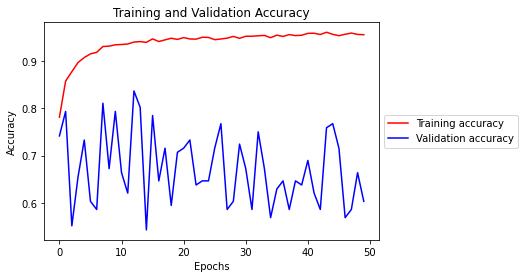

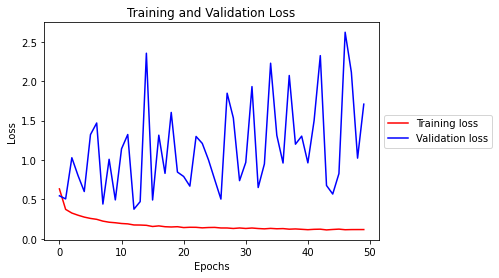

In [20]:
# Visualize the training results for both datasets
def visualize_training_results(results):
    acc = results.history['acc']
    val_acc = results.history['val_acc']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

visualize_training_results(baseline)

### Regularizing the Baseline Model:

In [21]:
# Regularize the baseline model
regularized_model = Sequential()
regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
regularized_model.add(Dense(8, activation='relu'))
regularized_model.add(Dense(1, activation = 'sigmoid'))
regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
results = regularized_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
82/82 [==============================] - 1s 14ms/step - loss: 0.9610 - acc: 0.7053 - val_loss: 1.9344 - val_acc: 0.5000
Epoch 2/50
82/82 [==============================] - 1s 13ms/step - loss: 0.9494 - acc: 0.7329 - val_loss: 0.8383 - val_acc: 0.5431
Epoch 3/50
82/82 [==============================] - 1s 12ms/step - loss: 0.8155 - acc: 0.7674 - val_loss: 0.4645 - val_acc: 0.8103
Epoch 4/50
82/82 [==============================] - 1s 14ms/step - loss: 0.8800 - acc: 0.7847 - val_loss: 1.6457 - val_acc: 0.5086
Epoch 5/50
82/82 [==============================] - 1s 14ms/step - loss: 0.7504 - acc: 0.7897 - val_loss: 0.9071 - val_acc: 0.5000
Epoch 6/50
82/82 [==============================] - 1s 14ms/step - loss: 0.7019 - acc: 0.7257 - val_loss: 0.7971 - val_acc: 0.5000
Epoch 7/50
82/82 [==============================] - 1s 13ms/step - loss: 0.5838 - acc: 0.7521 - val_loss: 0.6449 - val_acc: 0.6121
Epoch 8/50
82/82 [==============================] - 1s 14ms/step - loss: 0.6234 - a

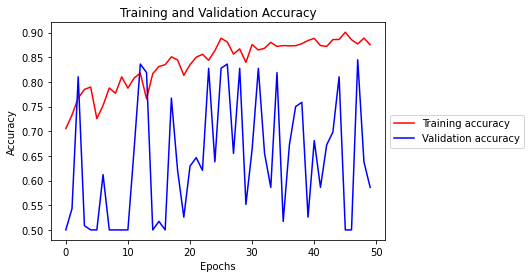

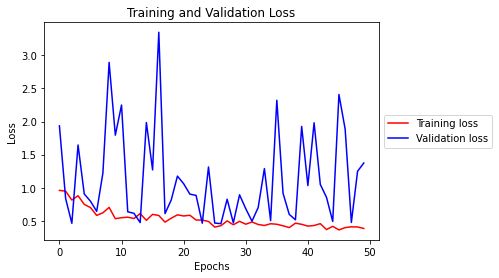

In [22]:
# Visualize the training results
visualize_training_results(results)

### Cross-Validating the Regularized Baseline Model:

In [26]:
# Create a function that will build the regularized model above
def build_reg_model():
    regularized_model = Sequential()
    regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
    regularized_model.add(Dense(8, activation='relu'))
    regularized_model.add(Dense(1, activation = 'sigmoid'))
    regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
    return regularized_model

In [27]:
# Cross-validate using various scikit-learn tools
keras_model = scikit_learn.KerasClassifier(build_reg_model,
                                          epochs=32,
                                          batch_size=64,
                                          verbose=2)
kfold = KFold(shuffle=True, random_state=seed)
validation_scores = cross_val_score(keras_model, X_train_final, y_train, cv=kfold)

Epoch 1/32
66/66 - 1s - loss: 1.0355 - acc: 0.7253
Epoch 2/32
66/66 - 1s - loss: 0.6098 - acc: 0.7514
Epoch 3/32
66/66 - 1s - loss: 0.5527 - acc: 0.8025
Epoch 4/32
66/66 - 1s - loss: 0.5907 - acc: 0.7567
Epoch 5/32
66/66 - 1s - loss: 0.6985 - acc: 0.7313
Epoch 6/32
66/66 - 1s - loss: 0.5915 - acc: 0.7558
Epoch 7/32
66/66 - 1s - loss: 0.5191 - acc: 0.8037
Epoch 8/32
66/66 - 1s - loss: 0.5286 - acc: 0.8080
Epoch 9/32
66/66 - 1s - loss: 0.5710 - acc: 0.8094
Epoch 10/32
66/66 - 1s - loss: 0.4689 - acc: 0.8447
Epoch 11/32
66/66 - 1s - loss: 0.5316 - acc: 0.8253
Epoch 12/32
66/66 - 1s - loss: 0.4888 - acc: 0.8490
Epoch 13/32
66/66 - 1s - loss: 0.4817 - acc: 0.8349
Epoch 14/32
66/66 - 1s - loss: 0.5225 - acc: 0.8327
Epoch 15/32
66/66 - 1s - loss: 0.4878 - acc: 0.8461
Epoch 16/32
66/66 - 1s - loss: 0.4947 - acc: 0.8459
Epoch 17/32
66/66 - 1s - loss: 0.4734 - acc: 0.8528
Epoch 18/32
66/66 - 1s - loss: 0.4845 - acc: 0.8674
Epoch 19/32
66/66 - 1s - loss: 0.7837 - acc: 0.8442
Epoch 20/32
66/66 - 1

Epoch 29/32
66/66 - 1s - loss: 0.4798 - acc: 0.8636
Epoch 30/32
66/66 - 1s - loss: 0.4608 - acc: 0.8581
Epoch 31/32
66/66 - 1s - loss: 0.4589 - acc: 0.8622
Epoch 32/32
66/66 - 1s - loss: 0.4532 - acc: 0.8617
17/17 - 0s - loss: 0.4872 - acc: 0.8217


In [28]:
# Calculate the training data's average validation score
validation_scores.mean()

0.8034719705581665

## Further Modeling
### Convolutional Neural Network (CNN):

In [29]:
# Construct the CNN model's framework
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(1, activation='sigmoid'))

CNNmodel.compile(loss='binary_crossentropy',
              optimizer="RMSprop",
              metrics=['acc'])

In [30]:
# Fit the CNN model
CNNresults = CNNmodel.fit(train_images,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_images, y_val))

Epoch 1/50
163/163 [==============================] - 16s 101ms/step - loss: 3.3879 - acc: 0.7673 - val_loss: 1.0889 - val_acc: 0.5948
Epoch 2/50
163/163 [==============================] - 16s 99ms/step - loss: 0.4431 - acc: 0.8827 - val_loss: 2.4100 - val_acc: 0.5603
Epoch 3/50
163/163 [==============================] - 16s 96ms/step - loss: 0.2163 - acc: 0.9245 - val_loss: 1.8768 - val_acc: 0.6466
Epoch 4/50
163/163 [==============================] - 16s 97ms/step - loss: 0.1743 - acc: 0.9517 - val_loss: 1.8350 - val_acc: 0.6466
Epoch 5/50
163/163 [==============================] - 16s 98ms/step - loss: 0.1356 - acc: 0.9548 - val_loss: 1.6618 - val_acc: 0.6552
Epoch 6/50
163/163 [==============================] - 16s 98ms/step - loss: 0.1045 - acc: 0.9668 - val_loss: 4.0245 - val_acc: 0.5690
Epoch 7/50
163/163 [==============================] - 16s 96ms/step - loss: 0.0984 - acc: 0.9697 - val_loss: 2.2107 - val_acc: 0.6724
Epoch 8/50
163/163 [==============================] - 16s 96m

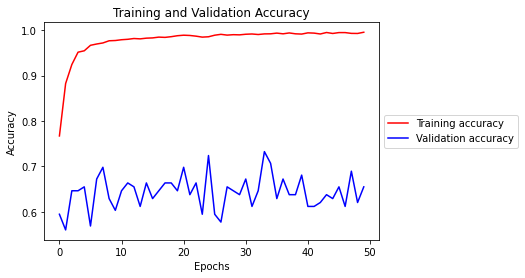

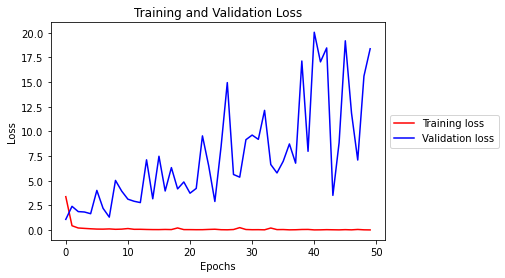

In [31]:
# Visualize the training results
visualize_training_results(CNNresults)

### Data Augmentation

In [32]:
# Reshape the training data for augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=[1, 1.5], 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

In [33]:
# Get all the data in the training directory (in batches) and standardize
train_generator_aug = train_datagen.flow_from_directory(
    train_data_dir, target_size=(64, 64), 
    batch_size=32, seed=seed, class_mode='binary')

# Get all the data in the test directory and standardize
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir, target_size=(64, 64), 
    batch_size = 524, seed=seed, class_mode='binary') 

# Get all the data in the validation directory (in batches) and standardize
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir, target_size=(64, 64),
    batch_size = 32, seed=seed, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [34]:
# Build a CNN model framework using the augmented training data
augCNNmodel = Sequential()
augCNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Flatten())
augCNNmodel.add(Dense(64, activation='relu'))
augCNNmodel.add(Dense(1, activation='sigmoid'))

augCNNmodel.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [35]:
#Create a file name object for the best model checkpoint
model_filepath = 'best_aug_model.h5'

# Set early stopping and model checkpoint parameters
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [36]:
# Fit the augmented CNN model
augCNNresults = augCNNmodel.fit(train_generator_aug,
                                epochs=32,
                                callbacks=early_stopping,
                                validation_data=val_generator)

Epoch 1/32
163/163 [==============================] - 144s 886ms/step - loss: 0.5508 - acc: 0.7429 - val_loss: 0.7118 - val_acc: 0.5000
Epoch 2/32
163/163 [==============================] - 88s 542ms/step - loss: 0.4878 - acc: 0.7604 - val_loss: 0.6115 - val_acc: 0.6379
Epoch 3/32
163/163 [==============================] - 89s 546ms/step - loss: 0.4392 - acc: 0.7887 - val_loss: 0.5346 - val_acc: 0.7672
Epoch 4/32
163/163 [==============================] - 89s 546ms/step - loss: 0.4089 - acc: 0.8067 - val_loss: 0.5031 - val_acc: 0.7759
Epoch 5/32
163/163 [==============================] - 88s 542ms/step - loss: 0.3951 - acc: 0.8179 - val_loss: 0.4841 - val_acc: 0.8103
Epoch 6/32
163/163 [==============================] - 88s 540ms/step - loss: 0.3715 - acc: 0.8324 - val_loss: 0.5144 - val_acc: 0.7414
Epoch 7/32
163/163 [==============================] - 89s 543ms/step - loss: 0.3605 - acc: 0.8391 - val_loss: 0.5075 - val_acc: 0.7672
Epoch 8/32
163/163 [==============================] - 

In [37]:
# Load the best (saved) model for the augmented data
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(train_generator_aug)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_generator)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

163/163 [==============================] - 84s 517ms/step - loss: 0.2748 - acc: 0.8865
Training Loss: 0.275 
Training Accuracy: 0.887
----------
4/4 [==============================] - 1s 340ms/step - loss: 0.4272 - acc: 0.7931
Validation Loss: 0.427 
Validation Accuracy: 0.793


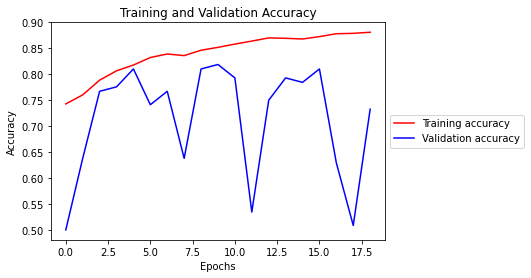

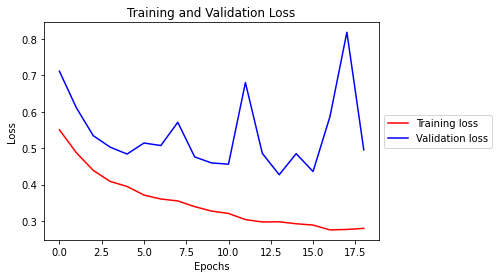

In [38]:
# Plot the training results
visualize_training_results(augCNNresults)

### Transfer Learning Approach:

In [39]:
# Instantiate the CNN base object
cnn_base = ResNet50(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

# Preview the various parameters that will be trained
cnn_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
# Build a network with the CNN base
resnet_model = Sequential()
resnet_model.add(cnn_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

# Freeze the base model
cnn_base.trainable = False

# List all the trainable layers
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, check how many trainable weights are in the model 
print(f'Trainable weights: {len(resnet_model.trainable_weights)}\n')

# Preview the various parameters and output shapes, once again
resnet_model.summary()

resnet50 False
flatten_3 True
dense_42 True
dense_43 True
Trainable weights: 4

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 2,097,665
Non-trainable params: 23,587,712
_________________________________________________________________


In [45]:
# Compile the transfer learning model
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=.001),
              metrics=['acc'])

# Fit the model
resnet_results = resnet_model.fit(train_generator_aug,
                              epochs=10,
                              validation_data=val_generator)

Epoch 1/10
163/163 [==============================] - 125s 764ms/step - loss: 0.5114 - acc: 0.7628 - val_loss: 0.6087 - val_acc: 0.6207
Epoch 2/10
163/163 [==============================] - 119s 728ms/step - loss: 0.4396 - acc: 0.7951 - val_loss: 0.8970 - val_acc: 0.5431
Epoch 3/10
163/163 [==============================] - 121s 744ms/step - loss: 0.4194 - acc: 0.8089 - val_loss: 0.4195 - val_acc: 0.8103
Epoch 4/10
163/163 [==============================] - 118s 723ms/step - loss: 0.4120 - acc: 0.8108 - val_loss: 0.5337 - val_acc: 0.6638
Epoch 5/10
163/163 [==============================] - 125s 764ms/step - loss: 0.4025 - acc: 0.8188 - val_loss: 0.4381 - val_acc: 0.8448
Epoch 6/10
163/163 [==============================] - 124s 760ms/step - loss: 0.4036 - acc: 0.8144 - val_loss: 0.6196 - val_acc: 0.6293
Epoch 7/10
163/163 [==============================] - 117s 721ms/step - loss: 0.4039 - acc: 0.8112 - val_loss: 0.9117 - val_acc: 0.5690
Epoch 8/10
163/163 [============================

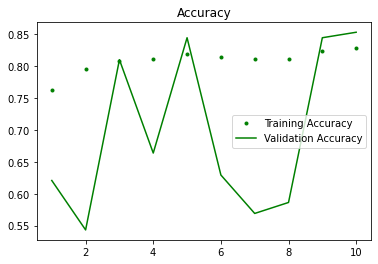

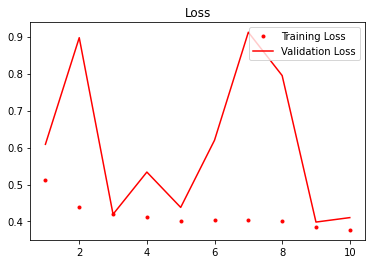

In [46]:
# Plot the training results using different markers
resnet_train_acc = resnet_results.history['acc']
resnet_val_acc = resnet_results.history['val_acc']
resnet_train_loss = resnet_results.history['loss']
resnet_val_loss = resnet_results.history['val_loss']
epch = range(1, len(resnet_train_acc) + 1)

plt.plot(epch, resnet_train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, resnet_val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, resnet_train_loss, 'r.', label='Training Loss')
plt.plot(epch, resnet_val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Deployment & Evaluation

In [47]:
# Evaluate the test data and list testing accuracy
test_loss, test_acc = saved_model.evaluate(test_generator)
y_hat_test = saved_model.predict(test_generator)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

1/1 [==============================] - 0s 2ms/step - loss: 0.3617 - acc: 0.8588
Generated 524 predictions
test acc: 0.8587786555290222


## Conclusion

## Limitations & Further Work